In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mitbit-arrhythmia-database/mitbih_database/112annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/233.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/108.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/118annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/231.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/207.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/115annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/108annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/123annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/102annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/209.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/203annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/202annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/215annotat

In [2]:
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential , Model
from keras.layers import Dense, LSTM, Dropout, Softmax, Flatten
import math
from sklearn.metrics import mean_squared_error

In [3]:
from tensorflow.keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers

In [4]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [5]:
path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'A', 'V', 'F', 'f']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [6]:
filenames = next(os.walk(path))[2]
records = list()
annotations = list()
filenames.sort()

In [7]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)
    else:
        annotations.append(path + filename + file_extension)

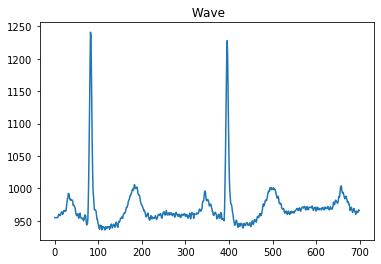

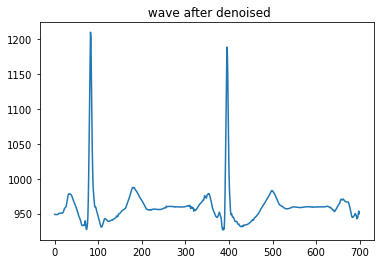

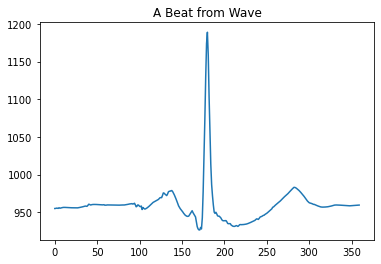

(86470, 360) (86470,)


In [8]:
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    if r is 1:
        plt.title(" Wave")
        plt.plot(signals[0:700])
        plt.show()
    signals = denoise(signals)
    if r is 1:
        plt.title(" wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()
        for d in range(1, len(data)): 
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) 
            pos = int(next(splitted))
            arrhythmia_type = next(splitted)
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True
                    X.append(beat)
                    y.append(arrhythmia_index)

print(np.shape(X), np.shape(y))

In [9]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
print(np.shape(X))

(86470, 361)


In [10]:
X_train_df = pd.DataFrame(X)
X_train_df

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,963.374455,963.536949,964.756621,965.399062,966.017086,966.375099,966.610054,966.770207,966.863751,966.951485,...,962.278640,962.282842,962.301737,962.395261,962.294270,961.799296,963.125729,961.823215,962.056695,0.0
1,950.134075,950.900959,951.742885,951.389255,952.444730,952.698845,952.985557,953.265506,953.554840,953.878155,...,957.912677,957.910661,957.908414,957.887200,957.930868,958.046497,957.767864,957.935546,957.848457,0.0
2,956.855367,957.921859,958.970263,960.062874,961.063537,961.544535,961.778225,961.903495,961.914781,961.927284,...,962.793234,963.018453,963.291927,963.610334,963.801834,963.664744,964.690013,963.714316,963.719371,0.0
3,956.333844,956.469719,956.650190,956.840204,957.063040,957.289795,957.532154,957.763758,957.903596,958.002126,...,963.483037,963.849264,964.232722,964.751295,965.325454,965.385283,965.277388,965.949119,966.749783,0.0
4,950.051087,950.080657,950.899845,951.943309,952.584266,953.144752,953.758744,954.385010,955.116512,955.847917,...,962.082603,962.257165,962.430031,962.608560,962.787336,962.969444,963.152923,963.315874,963.472298,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86465,960.091597,958.332371,959.228982,959.937280,960.462593,960.875403,961.311190,961.743369,962.152282,962.574638,...,964.516509,965.081464,965.657630,965.508808,965.080290,964.863438,964.607543,964.151499,963.933098,0.0
86466,960.158109,960.774672,961.122588,962.403698,963.542825,966.482368,966.960323,967.707577,968.022530,968.521270,...,963.553957,962.929216,962.408595,961.909285,961.207912,960.546289,959.842670,959.283797,959.529191,0.0
86467,959.520187,958.437111,959.105015,959.603769,960.050059,961.738668,962.600041,960.552121,957.583658,959.426743,...,968.586538,969.176431,969.713374,970.199836,970.198314,970.071392,969.631823,969.133521,969.677513,0.0
86468,957.960255,957.948389,959.213426,959.568639,959.893190,960.498387,961.169668,961.611360,961.984491,962.369367,...,974.808446,973.751860,972.810871,971.849649,970.724459,969.718156,968.525272,967.561324,968.065026,0.0


In [11]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)

0.0    75011
2.0     7129
1.0     2546
4.0      982
3.0      802
Name: 360, dtype: int64


In [12]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=42)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=42)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=42)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=42)
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [13]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 360, dtype: int64


In [14]:
train, test = train_test_split(X_train_df, test_size=0.20)
print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [15]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [16]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


In [17]:
print(train_x)

[[[ 969.229754  ]
  [ 968.83977425]
  [ 969.19699596]
  ...
  [1181.09410694]
  [1146.6050939 ]
  [1105.78430358]]

 [[ 898.50379129]
  [ 898.26061388]
  [ 898.07480387]
  ...
  [ 999.16116583]
  [ 994.96853369]
  [ 991.06116718]]

 [[ 939.51612205]
  [ 942.41768355]
  [ 944.88178569]
  ...
  [ 996.65854019]
  [ 995.7556791 ]
  [ 994.94867995]]

 ...

 [[ 860.17907069]
  [ 849.24510931]
  [ 835.90883159]
  ...
  [ 952.95635626]
  [ 944.73070748]
  [ 931.65232075]]

 [[ 986.14089604]
  [ 986.57699433]
  [ 986.50232843]
  ...
  [ 973.4186231 ]
  [ 973.98706213]
  [ 974.48850181]]

 [[ 973.24883363]
  [ 973.27066423]
  [ 973.32784046]
  ...
  [1210.16365224]
  [1208.75434527]
  [1201.29479659]]]


In [18]:
model1 = Sequential()
model1.add(LSTM(units=50, return_sequences=True, activation='tanh', input_shape=(360,1)))
model1.add(LSTM(units=10, return_sequences=True, activation='tanh'))
model1.add(Flatten())
model1.add(Dropout(0.5))
model1.add(Dense(35))
model1.add(Dense(5))
model1.add(Softmax())

2022-06-21 10:48:33.278258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 10:48:33.440493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 10:48:33.441334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 10:48:33.443138: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [19]:
model1.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [20]:
history  = model1.fit(train_x, train_y, batch_size=128, epochs=60, verbose=1, validation_data=(test_x, test_y))

2022-06-21 10:48:36.698678: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-06-21 10:48:40.385493: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


157/157 [==============================] - 12s 42ms/step - loss: 1.6814 - accuracy: 0.2010 - val_loss: 1.6079 - val_accuracy: 0.2154
Epoch 2/60
157/157 [==============================] - 6s 37ms/step - loss: 1.5991 - accuracy: 0.2277 - val_loss: 1.5805 - val_accuracy: 0.2642
Epoch 3/60
157/157 [==============================] - 6s 37ms/step - loss: 1.6043 - accuracy: 0.2499 - val_loss: 1.6121 - val_accuracy: 0.2186
Epoch 4/60
157/157 [==============================] - 6s 37ms/step - loss: 1.5722 - accuracy: 0.2628 - val_loss: 1.5396 - val_accuracy: 0.3298
Epoch 5/60
157/157 [==============================] - 6s 37ms/step - loss: 1.5471 - accuracy: 0.2885 - val_loss: 1.5131 - val_accuracy: 0.3634
Epoch 6/60
157/157 [==============================] - 6s 37ms/step - loss: 1.4966 - accuracy: 0.3498 - val_loss: 1.3784 - val_accuracy: 0.4298
Epoch 7/60
157/157 [==============================] - 6s 37ms/step - loss: 1.3527 - accuracy: 0.4500 - val_loss: 1.3086 - val_accuracy: 0.4690
Epoch 8/6

In [21]:
score1 = model1.evaluate(test_x, test_y)
print(score1[1])

157/157 [==============================] - 2s 14ms/step - loss: 0.5116 - accuracy: 0.8098
0.8098000288009644


In [22]:
def speci(kcm):
    total=sum(sum(kcm))
    sensitivity1 = kcm[0,0]/(kcm[0,0]+kcm[0,1]+kcm[0,2]+kcm[0,3]+kcm[0,4])
    print('Sensitivity of  Non-ecotic beats (normal beat) ', sensitivity1 )
    specificity1 = (kcm[1,1]+kcm[2,2]+kcm[3,3]+kcm[4,4])/(total-(kcm[0,0]+kcm[0,1]+kcm[0,2]+kcm[0,3]+kcm[0,4]))
    print('Specificity of  Non-ecotic beats (normal beat) ', specificity1)
    sensitivity1 = kcm[1,1]/(kcm[1,0]+kcm[1,1]+kcm[1,2]+kcm[1,3]+kcm[1,4])
    print('Sensitivity of  Supraventricular ectopic beats ', sensitivity1 )
    specificity1 = (kcm[0,0]+kcm[2,2]+kcm[3,3]+kcm[4,4])/(total-(kcm[1,0]+kcm[1,1]+kcm[1,2]+kcm[1,3]+kcm[1,4]))
    print('Specificity of  Supraventricular ectopic beats ', specificity1)
    sensitivity1 = kcm[2,2]/(kcm[2,0]+kcm[2,1]+kcm[2,2]+kcm[2,3]+kcm[2,4])
    print('Sensitivity of  Ventricular ectopic beats  ', sensitivity1 )
    specificity1 = (kcm[1,1]+kcm[0,0]+kcm[3,3]+kcm[4,4])/(total-(kcm[2,0]+kcm[2,1]+kcm[2,2]+kcm[2,3]+kcm[2,4]))
    print('Specificity of  Ventricular ectopic beats ', specificity1)
    sensitivity1 = kcm[3,3]/(kcm[3,0]+kcm[3,1]+kcm[3,2]+kcm[3,3]+kcm[3,4])
    print('Sensitivity of  Fusion Beats ', sensitivity1 )
    specificity1 = (kcm[1,1]+kcm[2,2]+kcm[0,0]+kcm[4,4])/(total-(kcm[3,0]+kcm[3,1]+kcm[3,2]+kcm[3,3]+kcm[3,4]))
    print('Specificity of  Fusion Beats ', specificity1)
    sensitivity1 = kcm[4,4]/(kcm[4,0]+kcm[4,1]+kcm[4,2]+kcm[4,3]+kcm[4,4])
    print('Sensitivity of  Unknown Beats ', sensitivity1 )
    specificity1 = (kcm[1,1]+kcm[2,2]+kcm[3,3]+kcm[0,0])/(total-(kcm[4,0]+kcm[4,1]+kcm[4,2]+kcm[4,3]+kcm[4,4]))
    print('Specificity of  Unknown Beats ', specificity1)
    

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
Y_pred = model1.predict(test_x)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(test_y,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print(confusion_mtx)
print(classification_report(Y_true, Y_pred_classes))
speci(confusion_mtx)

[[748 134   6  55  73]
 [230 766  13   4  33]
 [ 47  67 749  64  36]
 [ 76  10  40 831  19]
 [ 29   6   6   3 955]]
              precision    recall  f1-score   support

           0       0.66      0.74      0.70      1016
           1       0.78      0.73      0.76      1046
           2       0.92      0.78      0.84       963
           3       0.87      0.85      0.86       976
           4       0.86      0.96      0.90       999

    accuracy                           0.81      5000
   macro avg       0.82      0.81      0.81      5000
weighted avg       0.82      0.81      0.81      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.7362204724409449
Specificity of  Non-ecotic beats (normal beat)  0.8285642570281124
Sensitivity of  Supraventricular ectopic beats  0.7323135755258127
Specificity of  Supraventricular ectopic beats  0.8302984319676278
Sensitivity of  Ventricular ectopic beats   0.7777777777777778
Specificity of  Ventricular ectopic beats  0.8174386920980926
Se

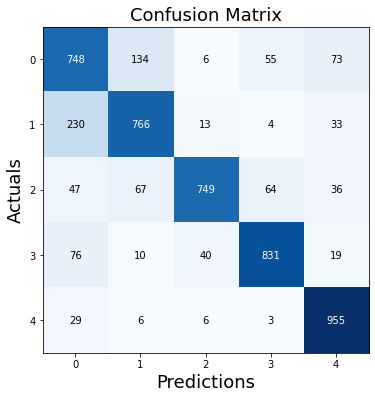

In [24]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=confusion_mtx, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [25]:
model_feat = Model(inputs=model1.input,outputs=model1.get_layer('flatten').output)
feat_train = model_feat.predict(train_x)
print(feat_train.shape)
feat_test = model_feat.predict(test_x)
print(feat_test.shape)

(20000, 3600)
(5000, 3600)


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
start0 = time.time()
sc = StandardScaler()
X_train = sc.fit_transform(feat_train)
X_test = sc.transform(feat_test)
pca = PCA(n_components = 150)
pca_X_train = pca.fit_transform(X_train)
pca_X_test = pca.transform(X_test)
stop0 = time.time()
print(f"Time: {stop0 - start0}s")

Time: 6.1756911277771s


In [27]:
print(pca_X_train.shape)
print(pca_X_test.shape)

(20000, 150)
(5000, 150)


In [28]:
import time

In [29]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
t0=time.time()
svm.fit(pca_X_train,np.argmax(train_y,axis=1))
t1=time.time()
print(f"Training time: {t1-t0}s")

Training time: 21.349542379379272s


In [30]:
t2=time.time()
Pred_labels = svm.predict(pca_X_test)
t3=time.time()
print(Pred_labels )
print(f"Testing time: {t3-t1}s")

[1 0 0 ... 2 2 1]
Testing time: 9.822591781616211s


In [31]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,Pred_labels)
print("Accuracy:",accuracy)

Accuracy: 0.9282


In [32]:
cm = confusion_matrix(target_test, Pred_labels) 
print(cm)
print(classification_report(target_test, Pred_labels))
speci(cm)

[[916  42   6  33  19]
 [101 932   7   3   3]
 [ 19   8 910  23   3]
 [ 38   2  22 909   5]
 [ 14   8   3   0 974]]
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      1016
         1.0       0.94      0.89      0.91      1046
         2.0       0.96      0.94      0.95       963
         3.0       0.94      0.93      0.94       976
         4.0       0.97      0.97      0.97       999

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.9015748031496063
Specificity of  Non-ecotic beats (normal beat)  0.9349899598393574
Sensitivity of  Supraventricular ectopic beats  0.8910133843212237
Specificity of  Supraventricular ectopic beats  0.9380374304501771
Sensitivity of  Ventricular ectopic beats   0.944963655244029
Specificity of  Ventricular ectopic beats  0.924201139459995
Sens

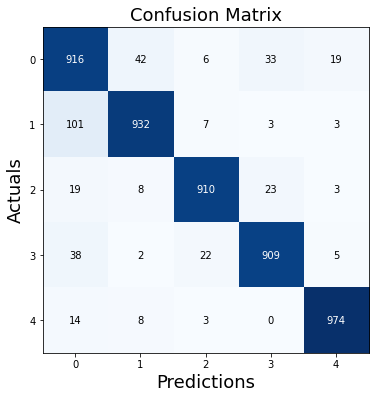

In [33]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [34]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
t4=time.time()
knn.fit(pca_X_train,np.argmax(train_y,axis=1))
t5=time.time()
print(f"Training time: {t5-t4}s")

Training time: 1.1337459087371826s


In [35]:
t6=time.time()
knn_labels = knn.predict(pca_X_test)
t7=time.time()
print(knn_labels )
print(f"Testing time: {t7-t6}s")

[1 0 1 ... 2 2 1]
Testing time: 5.548200845718384s


In [36]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,knn_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, knn_labels) 
print(cm)
print(classification_report(target_test, knn_labels))
speci(cm)

Accuracy: 0.9422
[[893  50   3  39  31]
 [ 41 991   8   2   4]
 [ 29  18 875  34   7]
 [  6   0   5 965   0]
 [  6   4   1   1 987]]
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90      1016
         1.0       0.93      0.95      0.94      1046
         2.0       0.98      0.91      0.94       963
         3.0       0.93      0.99      0.96       976
         4.0       0.96      0.99      0.97       999

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.8789370078740157
Specificity of  Non-ecotic beats (normal beat)  0.9583333333333334
Sensitivity of  Supraventricular ectopic beats  0.9474187380497132
Specificity of  Supraventricular ectopic beats  0.9408194233687405
Sensitivity of  Ventricular ectopic beats   0.9086188992731049
Specificity of  Ventricular ectopic beats  0.95

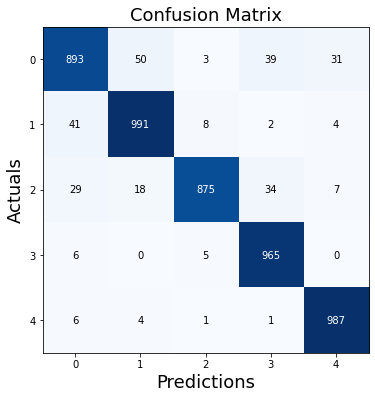

In [37]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [38]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='sigmoid')
t8=time.time()
svclassifier.fit(pca_X_train,np.argmax(train_y,axis=1))
t9=time.time()
print(f"Training time: {t9-t8}s")

Training time: 37.79209756851196s


In [39]:
t10=time.time()
svm_labels = svclassifier.predict(pca_X_test)
t11=time.time()
print(svm_labels )
print(f"Testing time: {t11-t10}s")

[1 0 0 ... 2 1 1]
Testing time: 10.8064706325531s


In [40]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,svm_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, svm_labels) 
print(cm)
print(classification_report(target_test, svm_labels))
speci(cm)

Accuracy: 0.596
[[500 372  62  17  65]
 [334 654  46   1  11]
 [141 146 609  33  34]
 [228  51  77 572  48]
 [227 112  15   0 645]]
              precision    recall  f1-score   support

         0.0       0.35      0.49      0.41      1016
         1.0       0.49      0.63      0.55      1046
         2.0       0.75      0.63      0.69       963
         3.0       0.92      0.59      0.72       976
         4.0       0.80      0.65      0.72       999

    accuracy                           0.60      5000
   macro avg       0.66      0.60      0.62      5000
weighted avg       0.66      0.60      0.61      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.4921259842519685
Specificity of  Non-ecotic beats (normal beat)  0.6224899598393574
Sensitivity of  Supraventricular ectopic beats  0.6252390057361377
Specificity of  Supraventricular ectopic beats  0.5882650480526049
Sensitivity of  Ventricular ectopic beats   0.632398753894081
Specificity of  Ventricular ectopic beats  0.5873

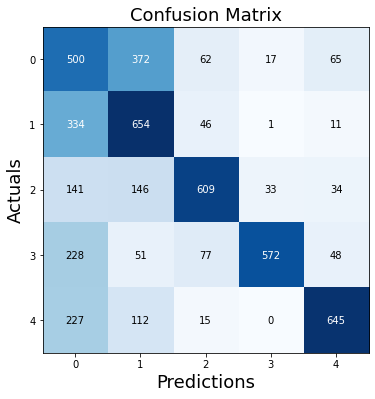

In [41]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [42]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly', degree=8)
t12=time.time()
svclassifier.fit(pca_X_train,np.argmax(train_y,axis=1))
t13=time.time()
print(f"Training time: {t13-t12}s")

Training time: 82.12112617492676s


In [43]:
t14=time.time()
svm_labels = svclassifier.predict(pca_X_test)
t15=time.time()
print(svm_labels )
print(f"Testing time: {t15-t14}s")

[4 4 4 ... 2 4 4]
Testing time: 12.563600778579712s


In [44]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,svm_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, svm_labels) 
print(cm)
print(classification_report(target_test, svm_labels))
speci(cm)

Accuracy: 0.6146
[[332  23   4  13 644]
 [ 11 382   2   0 651]
 [  7   6 755   5 190]
 [  4   1   0 610 361]
 [  3   2   0   0 994]]
              precision    recall  f1-score   support

         0.0       0.93      0.33      0.48      1016
         1.0       0.92      0.37      0.52      1046
         2.0       0.99      0.78      0.88       963
         3.0       0.97      0.62      0.76       976
         4.0       0.35      0.99      0.52       999

    accuracy                           0.61      5000
   macro avg       0.83      0.62      0.63      5000
weighted avg       0.83      0.61      0.63      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.32677165354330706
Specificity of  Non-ecotic beats (normal beat)  0.6880020080321285
Sensitivity of  Supraventricular ectopic beats  0.3652007648183556
Specificity of  Supraventricular ectopic beats  0.6805766312594841
Sensitivity of  Ventricular ectopic beats   0.7840083073727934
Specificity of  Ventricular ectopic beats  0.5

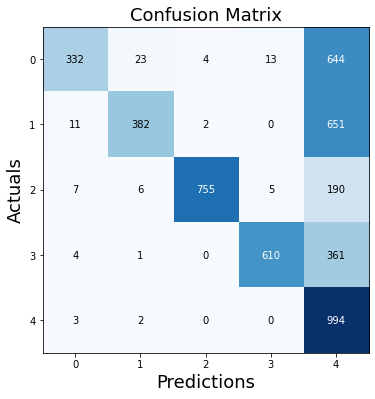

In [45]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [46]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
t16=time.time()
gnb.fit(pca_X_train,np.argmax(train_y,axis=1))
t17=time.time()
print(f"Training time: {t17-t16}s")

Training time: 0.02015089988708496s


In [47]:
t18=time.time()
gnb_labels = gnb.predict(pca_X_test)
t19=time.time()
print(gnb_labels )
print(f"Testing time: {t19-t18}s")

[4 4 4 ... 0 4 1]
Testing time: 0.016973018646240234s


In [48]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,gnb_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, gnb_labels) 
print(cm)
print(classification_report(target_test, gnb_labels))
speci(cm)

Accuracy: 0.4544
[[182 207  89  49 489]
 [ 70 304  84  27 561]
 [ 59  52 468 282 102]
 [ 31  15 142 492 296]
 [ 17   9  97  50 826]]
              precision    recall  f1-score   support

         0.0       0.51      0.18      0.26      1016
         1.0       0.52      0.29      0.37      1046
         2.0       0.53      0.49      0.51       963
         3.0       0.55      0.50      0.52       976
         4.0       0.36      0.83      0.50       999

    accuracy                           0.45      5000
   macro avg       0.49      0.46      0.43      5000
weighted avg       0.49      0.45      0.43      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.17913385826771652
Specificity of  Non-ecotic beats (normal beat)  0.5245983935742972
Sensitivity of  Supraventricular ectopic beats  0.29063097514340347
Specificity of  Supraventricular ectopic beats  0.4977238239757208
Sensitivity of  Ventricular ectopic beats   0.48598130841121495
Specificity of  Ventricular ectopic beats  0

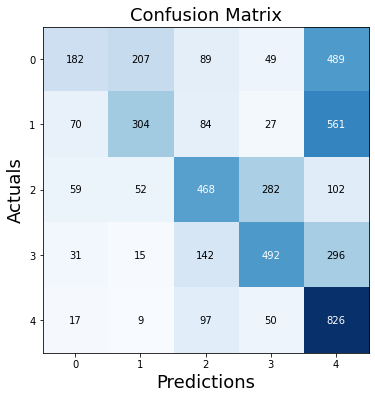

In [49]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [50]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
t20=time.time()
dt.fit(pca_X_train,np.argmax(train_y,axis=1))
t21=time.time()
print(f"Training time: {t21-t20}s")

Training time: 3.9890828132629395s


In [51]:
t22=time.time()
dt_labels = dt.predict(pca_X_test)
t23=time.time()
print(dt_labels )
print(f"Testing time: {t23-t22}s")

[1 0 1 ... 2 2 1]
Testing time: 0.002546072006225586s


In [52]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,dt_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, dt_labels) 
print(cm)
print(classification_report(target_test, dt_labels))
speci(cm)

Accuracy: 0.9456
[[ 848   62   56   22   28]
 [  13 1015   13    0    5]
 [  37   17  891   16    2]
 [   0    0    1  975    0]
 [   0    0    0    0  999]]
              precision    recall  f1-score   support

         0.0       0.94      0.83      0.89      1016
         1.0       0.93      0.97      0.95      1046
         2.0       0.93      0.93      0.93       963
         3.0       0.96      1.00      0.98       976
         4.0       0.97      1.00      0.98       999

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.94      5000
weighted avg       0.95      0.95      0.94      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.8346456692913385
Specificity of  Non-ecotic beats (normal beat)  0.9738955823293173
Sensitivity of  Supraventricular ectopic beats  0.9703632887189293
Specificity of  Supraventricular ectopic beats  0.9390490642387456
Sensitivity of  Ventricular ectopic beats   0.9252336448598131
Specificity of  Ventri

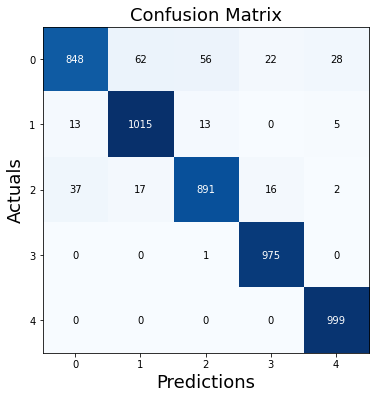

In [53]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


In [54]:
from sklearn.ensemble import RandomForestClassifier
rfc= RandomForestClassifier()
t24=time.time()
rfc.fit(pca_X_train,np.argmax(train_y,axis=1))
t25=time.time()
print(f"Training time: {t25-t24}s")

Training time: 19.448023080825806s


In [55]:
t26=time.time()
rfc_labels = rfc.predict(pca_X_test)
t27=time.time()
print(rfc_labels )
print(f"Testing time: {t27-t26}s")

[1 0 1 ... 2 2 1]
Testing time: 0.09280705451965332s


In [56]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,rfc_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, rfc_labels) 
print(cm)
print(classification_report(target_test, rfc_labels))
speci(cm)

Accuracy: 0.9812
[[ 957   16   25   16    2]
 [  14 1030    2    0    0]
 [  11    4  944    4    0]
 [   0    0    0  976    0]
 [   0    0    0    0  999]]
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96      1016
         1.0       0.98      0.98      0.98      1046
         2.0       0.97      0.98      0.98       963
         3.0       0.98      1.00      0.99       976
         4.0       1.00      1.00      1.00       999

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.9419291338582677
Specificity of  Non-ecotic beats (normal beat)  0.991214859437751
Sensitivity of  Supraventricular ectopic beats  0.9847036328871893
Specificity of  Supraventricular ectopic beats  0.9802731411229135
Sensitivity of  Ventricular ectopic beats   0.980269989615784
Specificity of  Ventricu

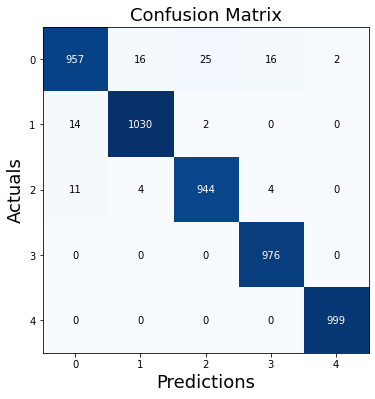

In [57]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [58]:
target= X_train_df[X_train_df.shape[1]-1]
feature = X_train_df.iloc[:,:X_train_df.shape[1]-1].values
feature = feature.reshape(len(feature), feature.shape[1],1)

In [59]:
feat = model_feat.predict(feature)
X_train = sc.fit_transform(feat)
pca = PCA(n_components = 150)
pca_train = pca.fit_transform(X_train)
print(pca_train.shape)
from sklearn.model_selection import cross_val_score
score = cross_val_score(rfc, pca_train, target, scoring='accuracy', cv=10)
print(score)

(25000, 150)
[0.9808 0.9804 0.9792 0.9788 0.9772 0.9836 0.9824 0.9836 0.9828 0.9792]


In [60]:
print("Avg :",np.average(score))

Avg : 0.9808
